Lambda School Data Science

*Unit 4, Sprint 2, Module 2*

---

# Backpropagation & Gradient Descent (Prepare)

## Learning Objectives
* <a href="#p1">Part 1</a>: Explain the intutition behind backproprogation
* <a href="#p2">Part 2</a>: Implement gradient descent + backpropagation on a feedforward neural network. 

## Summary of Yesterday

Yesterday, we learned about some of the principal components of Neural Networks: Neurons, Weights, Activation Functions, and layers (input, output, & hidden). Today, we will reinforce our understanding of those components and introduce the mechanics of training a neural network. Feed-forward neural networks, such as multi-layer perceptrons (MLPs), are almost always trained using some variation of gradient descent where the gradient has been calculated by backpropagation.

<center><img src="https://cdn-images-1.medium.com/max/1600/1*_M4bZyuwaGby6KMiYVYXvg.jpeg" width="400"></center>

- There are three kinds of layers: input, hidden, and output layers.
- Each layer is made up of **n** individual neurons (aka activation units) which have a corresponding weight and bias.
- Signal is passed from layer to layer through a network by:
 - Taking in inputs from the training data (or previous layer)
 - Multiplying each input by its corresponding weight (think arrow/connecting line)
 - Adding a bias to this weighted some of inputs and weights
 - Activating this weighted sum + bias by squishifying it with sigmoid or some other activation function. With a single perceptron with three inputs, calculating the output from the node is done like so:
\begin{align}
 y = sigmoid(\sum(weight_{1}input_{1} + weight_{2}input_{2} + weight_{3}input_{3}) + bias)
\end{align}
 - this final activated value is the signal that gets passed onto the next layer of the network.
 
 

## Training a Neural Network: *Formal Summary*

0. Pick a network architecture
   - No. of input units = No. of features
   - No. of output units = Number of Classes (or expected targets)
   - Select the number of hidden layers and number of neurons within each hidden layer
1. Randomly initialize weights
2. Implement forward propagation to get $h_{\theta}(x^{(i)})$ for any $x^{(i)}$
3. Implement code to compute a cost function $J(\theta)$
4. Implement backpropagation to compute partial derivatives $\frac{\delta}{\delta\theta_{jk}^{l}}{J(\theta)}$
5. Use gradient descent (or other advanced optimizer) with backpropagation to minimize $J(\theta)$ as a function of parameters $\theta\$
6. Repeat steps 2 - 5 until cost function is 'minimized' or some other stopping criteria is met. One pass over steps 2 - 5 is called an iteration or epoch.

## Calculating *"cost"*, *"loss"* or *"error"*

We've talked about how in order to evaluate a network's performance, the data is "fed forward" until predictions are obtained and then the "loss" or "error" for a given observation is ascertained by looking at what the network predicted for that observation and comparing it to what it *should* have predicted. 

The error for a given observation is calculated by taking the square of the difference between the predicted value and the actual value. 

We can summarize the overall quality of a network's predictions by finding the average error across all observations. This gives us the "Mean Squared Error." which hopefully is a fairly familiar model evaluation metric by now. Graphing the MSE over each epoch (training cycle) is a common practice with Neural Networks. This is what you're seeing in the top right corner of the Tensorflow Playground website as the number of "epochs" climbs higher and higher.

## What is an "Epoch"?

An "Epoch" is one cycle of passing our data forward through the network, measuring error given our specified cost function, and then -via gradient descent- updating weights within our network to hopefully improve the quality of our predictions on the next iteration.

### Batch vs Minibatch vs Stochastic Gradient Descent Epochs

You may have heard these variations on the training process referenced in the 3Blue1Brown videos about backpropagation. "Minibatch" Gradient Descent means that instead of passing all of our data through the network for a given epoch (Batch GD), we just pass a randomized portion of our data through the network for each epoch. 

Stochastic Gradient Descent is when we make updates to our weights after forward propagating each individual training observation.

### A note about Hyperparameters

Neural Networks have many more hyperparameters than other machine learning algorithms which is part of what makes them a beast to train.

1. You need more data to train them on. 
2. They're complex so they take longer to train. 
3. They have lots and lots of hyperparameters which we need to find the most optimal combination of, so we might end up training our model dozens or hundreds of times with different combinations of hyperparameters in order to try and squeeze out a few more tenths of a percent of accuracy. 

# Backpropagation (Learn)
<a id="p1"></a>

## Overview

Backpropagation is short for ["Backwards Propagation of errors"](https://en.wikipedia.org/wiki/Backpropagation) and refers to a specific (rather calculus intensive) algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch. Our purpose today is to demonstrate the backpropagation algorithm on a simple Feedforward Neural Network and in so doing help you get a grasp on the main process. If you want to understand all of the underlying calculus of how the gradients are calculated then you'll need to dive into it yourself, [3Blue1Brown's video is a great starting place](https://www.youtube.com/watch?v=tIeHLnjs5U8). I also highly recommend this Welch Labs series [Neural Networks Demystified](https://www.youtube.com/watch?v=bxe2T-V8XRs) if you want a rapid yet orderly walkthrough of the main intuitions and math behind the backpropagation algorithm. 

### What is a Gradient?

> In vector calculus, the gradient is a multi-variable generalization of the derivative. 

The gradients that we will deal with today will be vector representations of the derivative of the activation function. 

## Follow Along

In this section, we will again implement a multi-layer perceptron using numpy. We'll focus on using a __Feed Forward Neural Network__ to predict test scores. 

![231 Neural Network](https://cdn-images-1.medium.com/max/1600/1*IjY3wFF24sK9UhiOlf36Bw.png)

### Generate some Fake Data

In [1]:
import numpy as np

np.random.seed(812)

# hours studying, hours sleep
X = np.array((
             [2,9],
             [1,5],
             [3,6]), dtype=float)

# score on test
y = np.array(([92],
              [86],
              [89]), dtype=float)

### Feature Normalization

In [2]:
# Normalizing Data on feature 
# Neural Network would probably do this on its own, but it will help us converge on a solution faster
X = X / np.amax(X, axis=0)
y = y/100

print("Studying, Sleeping \n", X)
print("Test Score \n", y)

Studying, Sleeping 
 [[0.66666667 1.        ]
 [0.33333333 0.55555556]
 [1.         0.66666667]]
Test Score 
 [[0.92]
 [0.86]
 [0.89]]


### Neural Network Architecture
Lets create a Neural_Network class to contain this functionality

In [4]:
class NeuralNetwork:
    
    def __init__(self):
        # set up default values for number of inputs and hidden nodes
        self.inputs = 2 
        self.hiddenNodes = 3 
        self.outputNodes = 1
        
        # initialize weights
        # create 2 x 3 array since args are lengths of dimensions of array 
        self.weights1 = np.random.randn(self.inputs, self.hiddenNodes)
        # 3 x 1 
        self.weights2 = np.random.randn(self.hiddenNodes, self.outputNodes)
        
        # the correct way to do this is the write a .py file with the class and
        # import into the notebook
        # we are going to add to this class each section for learning purposes

In [7]:
# produces 3 x 5 array 
# np.random.randn(3,5)

array([[-1.75351135,  1.23279898,  0.24464757, -0.06568225,  0.30190098],
       [ 0.79723428,  1.23073545, -1.52187331, -0.25502715,  0.96808324],
       [-1.782362  , -0.75408522, -1.23115135,  0.62890718,  0.44526701]])

### Randomly Initialize Weights
How many random weights do we need to initialize? "Fully-connected Layers"

In [5]:
nn = NeuralNetwork()

In [6]:
print("Layer 1 weights: \n", nn.weights1)
print("Layer 2 weights: \n", nn.weights2)

Layer 1 weights: 
 [[ 2.48783189  0.11697987 -1.97118428]
 [-0.48325593 -1.50361209  0.57515126]]
Layer 2 weights: 
 [[-0.20672583]
 [ 0.41271104]
 [-0.57757999]]


### Implement Feedforward Functionality

After this step our neural network should be able to generate an output even though it has not been trained.

In [8]:
# add sigmoid helper function
class NeuralNetwork:
    
    def __init__(self):
        # set up default values for number of inputs and hidden nodes
        self.inputs = 2 
        self.hiddenNodes = 3 
        self.outputNodes = 1
        
        # initialize weights
        # create 2 x 3 array since args are lengths of dimensions of array 
        # first set of weights that are input to hidden
        self.weights1 = np.random.randn(self.inputs, self.hiddenNodes)
        # 3 x 1 
        # hidden to output
        self.weights2 = np.random.randn(self.hiddenNodes, self.outputNodes)
        
    #
    def sigmoid(self, s):
        return 1 / (1+np.exp(-s))
    
    def feed_forward(self, X):
        """
        Calculate the NN inference using feed forward.
        """
        
        # weighted sum
        self.hidden_sum = np.dot(X, self.weights1)
        
        # activate
        self.activated_hidden = self.sigmoid(self.hidden_sum)
        
        # weighted sum of activated hidden (which output will use)
        self.output_sum = np.dot(self.activated_hidden, self.weights2)
        
        # final activation of output (predictions) 
        self.activated_output = self.sigmoid(self.output_sum)
        
        return self.activated_output

In [9]:
X

array([[0.66666667, 1.        ],
       [0.33333333, 0.55555556],
       [1.        , 0.66666667]])

### Make a Prediction

In [10]:
# Try to make a prediction with our updated 'net on first entry

nn = NeuralNetwork()
output = nn.feed_forward(X[0])
print("intput", X[0])
print("output", output)

intput [0.66666667 1.        ]
output [0.65615242]


### Calculate Error

In [11]:
error = y[0] - output
error

array([0.26384758])

In [13]:
# throw array at it and it works
output_all = nn.feed_forward(X)
error_all = y - output_all
print(output_all)
print("\n")
print(error_all)

[[0.65615242]
 [0.66054813]
 [0.66411859]]


[[0.26384758]
 [0.19945187]
 [0.22588141]]


Why is my error so big?

My error is so big because my prediction is low.

Why are my prediction low?

Because either:

  1) Second layer **weights** are low
  
  (or)
  
  2) Activations coming from the first layer are low
  
How are activations from the first layer determined? 

  1) By inputs - fixed
  
  2) by **weights** - variable
  
The only thing that I have control over throughout this process in order to increase the value of my final predictions is to either increase weights in layer 2 or increase weights in layer 1. 

Imagine that you could only change your weights by a fixed amount. Say you have .3 and you have to split that up and disperse it over your weights so as to increase your predictions as much as possible. (This isn't actually what happens, but it will help us identify which weights we would benefit the most from moving.)

I need to increase weights of my model somewhere, I'll get the biggest bang for my buck if I increase weights in places where I'm already seeing high activation values -because they end up getting multiplied together before being passed to the sigmoid function. 

> "Neurons that fire together, wire together"

### Implement Backpropagation 

> *Assigning blame for bad predictions and delivering justice - repeatedly and a little bit at a time* - Jon Cody

What in our model could be causing our predictions to suck so bad? 

Well, we know that our inputs (X) and outputs (y) are correct, if they weren't then we would have bigger problems than understanding backpropagation.

We also know that our activation function (sigmoid) is working correctly. It can't be blamed because it just does whatever we tell it to and transforms the data in a known way.

So what are the potential culprits for these terrible predictions? The **weights** of our model. Here's the problem though. I have weights that exist in both layers of my model. How do I know if the weights in the first layer are to blame, or the second layer, or both? 

Lets investigate. And see if we can just eyeball what should be updated.

In [14]:
attributes = ['weights1', 'hidden_sum', 'activated_hidden', 'weights2', 'activated_output']
[print(i+'\n', getattr(nn,i), '\n'+'---'*3) for i in attributes if i[:2]!= '__'] 

weights1
 [[-1.78221311 -1.43272971  0.56695085]
 [ 0.27918014  0.24367902 -0.38241422]] 
---------
hidden_sum
 [[-0.90896194 -0.71147412 -0.00444699]
 [-0.43897096 -0.34219933 -0.02346873]
 [-1.59609302 -1.27027703  0.31200804]] 
---------
activated_hidden
 [[0.2872123  0.3292732  0.49888826]
 [0.3919862  0.41527533 0.49413309]
 [0.16852838 0.21920983 0.57737532]] 
---------
weights2
 [[-0.62133738]
 [ 1.03772343]
 [ 0.96806421]] 
---------
activated_output
 [[0.65615242]
 [0.66054813]
 [0.66411859]] 
---------


[None, None, None, None, None]

### Backpropagation (Simple Overview)

Our model has 9 total weights (6 in the first layer, 3 in the last layer) that could be off.

1) Calculate Error for a given each observation

2) Does the error indicate that I'm overestimating or underestimating in my prediction?

3) Look at final layer weights to get an idea for which weights are helping pass desirable signals and which are stifling desirable signals

4) Also go to the previous layer and see what can be done to boost activations that are associated with helpful weights, and limit activations that are associated with unhelpful weights.

### Update Weights Based on Gradient

Repeat steps 1-4 for every observation in a given batch, and then given the network's cost function, calculate its gradient using calculus and update weights associated with the (negative) gradient of the cost function. 

Increase weights of positive correlated weights and decrease weights of negative correlated weights. 

Remember that we have 9 weights in our network therefore the gradient that comes from our gradient descent calculation will be the vector that takes us in the most downward direction along some function in 9-dimensional hyperspace.

\begin{align}
C(w1, w2, w3, w4, w5, w6, w7, w8, w9)
\end{align}

You should also know that with neural networks it is common to have gradients that are not convex (like what we saw when we applied gradient descent to linear regression). Due to the high complexity of these models and their nonlinearity, it is common for gradient descent to get stuck in a local minimum, but there are ways to combat this:

1) Stochastic Gradient Descent

2) More advanced Gradient-Descent-based "Optimizers" - See Stretch Goals on assignment.

In [23]:
# I want activations that correspond to negative weights to be lower
# and activations that correspond to positive weights to be higher
# add backprop function

class NeuralNetwork:
    
    def __init__(self):
        # set up default values for number of inputs and hidden nodes
        self.inputs = 2 
        self.hiddenNodes = 3 
        self.outputNodes = 1
        
        # initialize weights
        # create 2 x 3 array since args are lengths of dimensions of array 
        # first set of weights that are input to hidden
        self.weights1 = np.random.randn(self.inputs, self.hiddenNodes)
        # 3 x 1 
        # hidden to output
        self.weights2 = np.random.randn(self.hiddenNodes, self.outputNodes)
        
    # sigmoid helper
    def sigmoid(self, s):
        return 1 / (1+np.exp(-s))
    
    # derivative
    def sigmoidPrime(self, s):
        sx = self.sigmoid(s)
        return sx * (1-sx)
    
    def feed_forward(self, X):
        """
        Calculate the NN inference using feed forward.
        """
        
        # weighted sum
        self.hidden_sum = np.dot(X, self.weights1)
        
        # activate
        self.activated_hidden = self.sigmoid(self.hidden_sum)
        
        # weighted sum of activated hidden (which output will use)
        self.output_sum = np.dot(self.activated_hidden, self.weights2)
        
        # final activation of output (predictions) 
        self.activated_output = self.sigmoid(self.output_sum)
        
        return self.activated_output
    
    def backward(self, X, y, o):
        """
        Back prop thru the network
        """
        # absolute error of original pass like from above
        self.o_error = y - o
        # partial derivative of error
        # not taking continuous, only at a single point
        self.o_delta = self.o_error * self.sigmoidPrime(o)
        # some new definitions
        # z2 error: how much our output layer weights were off
        self.z2_error = self.o_delta.dot(self.weights2.T)
        
        # z2 delta: how much were the weights off?
        self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden)
        
        self.weights1 += X.T.dot(self.z2_delta)
        self.weights2 += self.activated_hidden.T.dot(self.o_delta)
        
    def train(self, X, y):
        o = self.feed_forward(X)
        self.backward(X,y,o)

#### Let's look at the shape of the Gradient Componets


In [24]:
# from reference import NeuralNetwork

nn = NeuralNetwork()

nn.train(X,y)

##### Our Error Associated with Each Observation 
aka how wrong were we?

In [25]:
nn.o_error

array([[0.30127004],
       [0.21439603],
       [0.28875886]])

##### 1st Gradient 
Simple interpretation - how much more sigmoid activation would have pushed us towards the right answer?

`self.o_delta = self.o_error * self.sigmoidPrime(o)`

In [26]:
nn.o_delta # gradient, anywhere there's a delta in name is a gradient

array([[0.06854529],
       [0.04838019],
       [0.06603957]])

##### 2nd Error
Justice hasn't been served yet - tho. We still have neurons to blame. Let's go back another layer. 

`self.z2_error = self.o_delta.dot(self.weights2.T)`

__Discussion:__ Why is this shape different?

In [27]:
nn.z2_error # is 3x3 gradient from each neuron

array([[0.05236173, 0.00567766, 0.04433907],
       [0.03695761, 0.00400737, 0.03129511],
       [0.05044761, 0.00547011, 0.04271823]])

##### 2nd Gradient
For each observation, how much more sigmoid activation from this layer would have pushed us towards the right answer?

`self.z2_delta = self.z2_error * self.sigmoidPrime(self.activated_hidden)`

In [28]:
nn.z2_delta

array([[0.01295623, 0.00133879, 0.01055065],
       [0.00899639, 0.00094476, 0.00739263],
       [0.01250547, 0.00126151, 0.01036976]])

In [29]:
X.T.shape == nn.weights1.shape

True

##### Descent

*Discussion:* Input to Hidden Weight Update
- We multiply the gradient by the inputs. Why?
- Why do we need to transpose the inputs? 

In [30]:
X.T

array([[0.66666667, 0.33333333, 1.        ],
       [1.        , 0.55555556, 0.66666667]])

In [31]:
X.T.dot(nn.z2_delta) # dot brings weights in line given inputs towards direction
# go watch 3b1b 

array([[0.02414175, 0.00246896, 0.01986774],
       [0.0262912 , 0.00270467, 0.02157084]])

*Discussion:* Hidden to Output Weight Update
- Why is output the shape 3x1? 
- We multiply the gradient by the inputs. Why?
- Why do we need to transpose the inputs?

In [ ]:
nn.activated_hidden.T.dot(nn.o_delta) # this gives us our updated weights

# this is us stepping thru a single epoch

### Train the Network (fo real this time)

In [ ]:
# Train my 'net
nn = NeuralNetwork()

# Number of Epochs / Iterations
for i in range(10000):
    if (i+1 in [1,2,3,4,5]) or ((i+1) % 1000 ==0):
        print('+' + '---' * 3 + f'EPOCH {i+1}' + '---'*3 + '+')
        print('Input: \n', X)
        print('Actual Output: \n', y)
        print('Predicted Output: \n', str(nn.feed_forward(X)))
        print("Loss: \n", str(np.mean(np.square(y - nn.feed_forward(X)))))
    nn.train(X,y)

## Challenge

In the module project, you will implement backpropagation inside a multi-layer perceptron (aka a feedforward neural network). 

# Stochastic Gradient Descent (Learn)

## Overview

The What - Stochastic Gradient Descent calculates an approximation of the gradient over the entire dataset by reviewing the predictions of a random sample. 

The Why - *Speed*. Calculating the gradient over the entire dataset is extremely expensive computationally. 

## Follow Along

A true Stochastic GD-based implementation from [Welch Labs](https://www.youtube.com/watch?v=bxe2T-V8XRs)

In [34]:
class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [35]:
from scipy import optimize
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [36]:
NN = Neural_Network()

In [37]:
T = trainer(NN)

In [38]:
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 59
         Gradient evaluations: 59


In [39]:
print("Predicted Output: \n" + str(NN.forward(X))) 
print("Loss: \n" + str(np.mean(np.square(y - NN.forward(X))))) # mean sum squared loss

Predicted Output: 
[[0.91992581]
 [0.86004226]
 [0.89003057]]
Loss: 
2.7413328127263207e-09


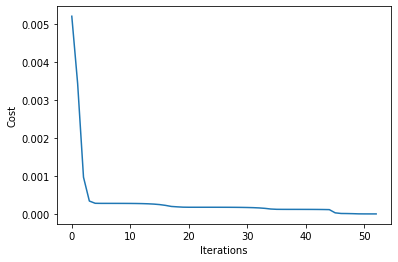

In [40]:
import matplotlib.pyplot as plt
plt.plot(T.J)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()     

## Challenge

This is a reference implementation for you to explore. You will not be expected to apply it to today's module project. 